In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

plt.rcParams.update({'font.size': 12})
plt.style.use('seaborn-v0_8-darkgrid') 

np.random.seed(33)

# Class 0 for D1
mean_d1_c0 = [2, 2]
cov_d1_c0 = [[0.8, 0.6], [0.6, 0.8]]
X_d1_c0 = np.random.multivariate_normal(mean_d1_c0, cov_d1_c0, 100)
y_d1_c0 = np.zeros(100)

# Class 1 for D1
mean_d1_c1 = [7, 7]
cov_d1_c1 = [[0.8, 0.6], [0.6, 0.8]]
X_d1_c1 = np.random.multivariate_normal(mean_d1_c1, cov_d1_c1, 100)
y_d1_c1 = np.ones(100)

# Combine D1 classes
X_d1 = np.vstack((X_d1_c0, X_d1_c1))
y_d1 = np.hstack((y_d1_c0, y_d1_c1))

# Class 0 for D2 (inner circle-ish)
theta_d2_c0 = 2 * np.pi * np.random.rand(100)
r_d2_c0 = 1 + 0.5 * np.random.randn(100)
X_d2_c0 = np.array([r_d2_c0 * np.cos(theta_d2_c0), r_d2_c0 * np.sin(theta_d2_c0)]).T
y_d2_c0 = np.zeros(100)

# Class 1 for D2 (outer circle-ish)
theta_d2_c1 = 2 * np.pi * np.random.rand(100)
r_d2_c1 = 3 + 0.5 * np.random.randn(100)
X_d2_c1 = np.array([r_d2_c1 * np.cos(theta_d2_c1), r_d2_c1 * np.sin(theta_d2_c1)]).T
y_d2_c1 = np.ones(100)

# Combine D2 classes
X_d2 = np.vstack((X_d2_c0, X_d2_c1))
y_d2 = np.hstack((y_d2_c0, y_d2_c1))

# For D1
# Temporarily split to get 20 test samples, then extract 10 from each class
X_train_d1, X_test_d1_temp, y_train_d1, y_test_d1_temp = train_test_split(
    X_d1, y_d1, test_size=20, stratify=y_d1, random_state=33
)
# Then, explicitly select the first 10 points from each class from the temporary test set
# to guarantee exactly 10 Class 0 and 10 Class 1 samples for T1.
T1_X = np.vstack((X_test_d1_temp[y_test_d1_temp == 0][:10], X_test_d1_temp[y_test_d1_temp == 1][:10]))
T1_y = np.hstack((y_test_d1_temp[y_test_d1_temp == 0][:10], y_test_d1_temp[y_test_d1_temp == 1][:10]))

# For D2
# Temporarily split to get 20 test samples, then extract 10 from each class
X_train_d2, X_test_d2_temp, y_train_d2, y_test_d2_temp = train_test_split(
    X_d2, y_d2, test_size=20, stratify=y_d2, random_state=33
)
T2_X = np.vstack((X_test_d2_temp[y_test_d2_temp == 0][:10], X_test_d2_temp[y_test_d2_temp == 1][:10]))
T2_y = np.hstack((y_test_d2_temp[y_test_d2_temp == 0][:10], y_test_d2_temp[y_test_d2_temp == 1][:10]))

# Define a helper function for plotting decision boundaries (will be used in later cells)
def plot_decision_boundary(model, X, y, title, ax, resolution=100):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.coolwarm, edgecolors='k')
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend(*scatter.legend_elements(), title="Classes")
    ax.grid(True, linestyle='--', alpha=0.7)


# --- Code to export data to data.txt ---
def export_data_segment(filename, data_name, X_data, y_data, open_mode):
    """
    Exports a segment of data (X and y) to a text file with a header and footer.
    """
    y_data_reshaped = y_data.reshape(-1, 1)
    combined_data = np.hstack((X_data, y_data_reshaped))

    with open(filename, open_mode) as f:
        f.write(f"--- {data_name} Data ---\n")
        f.write("Feature1\tFeature2\tLabel\n")
        np.savetxt(f, combined_data, fmt='%.6f', delimiter='\t')
        f.write(f"--- End of {data_name} Data ---\n\n")

# Export D1 data (write mode to create/overwrite the file)
export_data_segment('data.txt', 'D1', X_d1, y_d1, 'w')

# Export D2 data (append mode)
export_data_segment('data.txt', 'D2', X_d2, y_d2, 'a')

# Export T1 data (append mode)
export_data_segment('data.txt', 'T1', T1_X, T1_y, 'a')

# Export T2 data (append mode)
export_data_segment('data.txt', 'T2', T2_X, T2_y, 'a')

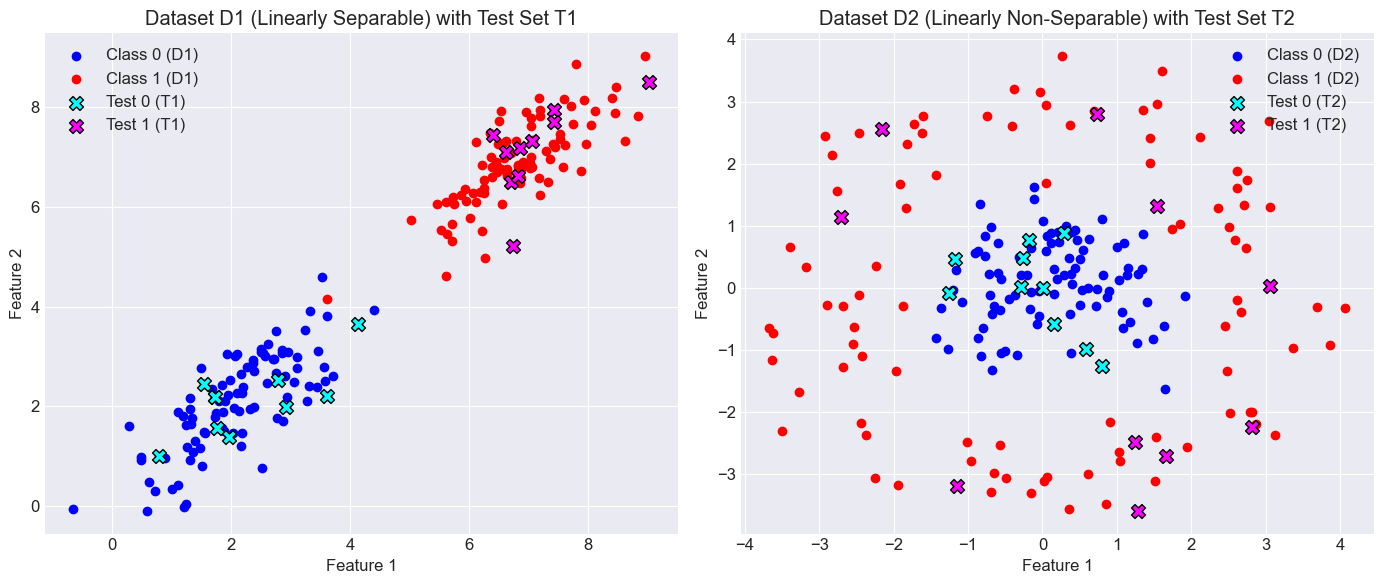

In [2]:
# Cell 2: Scatter Plots of D1 and D2

plt.figure(figsize=(14, 6))

# Plot D1 with its test set T1
plt.subplot(1, 2, 1)
plt.scatter(X_d1[y_d1 == 0, 0], X_d1[y_d1 == 0, 1], color='blue', label='Class 0 (D1)')
plt.scatter(X_d1[y_d1 == 1, 0], X_d1[y_d1 == 1, 1], color='red', label='Class 1 (D1)')
plt.scatter(T1_X[T1_y == 0, 0], T1_X[T1_y == 0, 1], color='cyan', marker='X', s=100, label='Test 0 (T1)', edgecolors='black')
plt.scatter(T1_X[T1_y == 1, 0], T1_X[T1_y == 1, 1], color='magenta', marker='X', s=100, label='Test 1 (T1)', edgecolors='black')
plt.title('Dataset D1 (Linearly Separable) with Test Set T1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

# Plot D2 with its test set T2
plt.subplot(1, 2, 2)
plt.scatter(X_d2[y_d2 == 0, 0], X_d2[y_d2 == 0, 1], color='blue', label='Class 0 (D2)')
plt.scatter(X_d2[y_d2 == 1, 0], X_d2[y_d2 == 1, 1], color='red', label='Class 1 (D2)')
plt.scatter(T2_X[T2_y == 0, 0], T2_X[T2_y == 0, 1], color='cyan', marker='X', s=100, label='Test 0 (T2)', edgecolors='black')
plt.scatter(T2_X[T2_y == 1, 0], T2_X[T2_y == 1, 1], color='magenta', marker='X', s=100, label='Test 1 (T2)', edgecolors='black')
plt.title('Dataset D2 (Linearly Non-Separable) with Test Set T2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

--- Hard-Margin SVM for D1 ---
Hard-Margin SVM Training Accuracy (D1): 0.9889
Hard-Margin SVM Test Accuracy (T1): 0.9500

Hard-Margin SVM Classification Report (T1):
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        10
         1.0       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



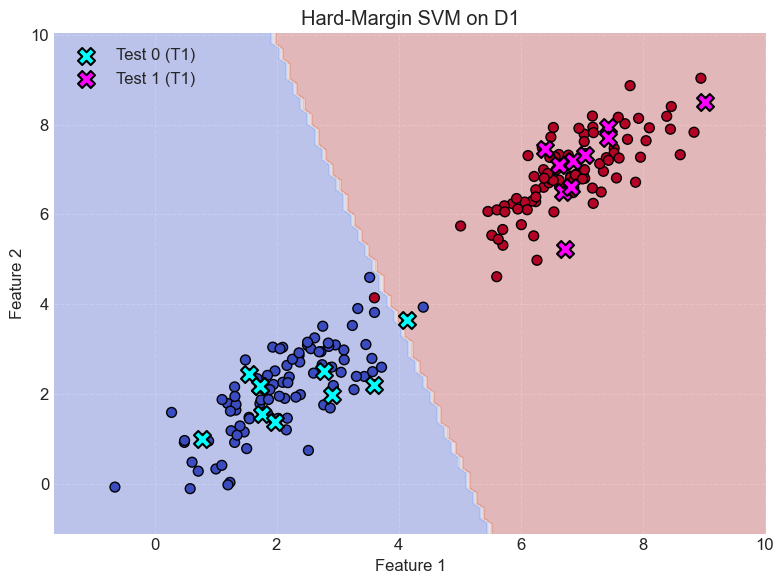

In [3]:
# Cell 3: Hard-Margin SVM for D1

print("--- Hard-Margin SVM for D1 ---")
# C=1e10 effectively makes it a hard-margin SVM for perfectly separable data.
# 'linear' kernel is appropriate for linearly separable data.
svm_hard_margin = SVC(kernel='linear', C=1e10, random_state=33)
svm_hard_margin.fit(X_train_d1, y_train_d1)

# Training results for D1
y_pred_d1_svm_train = svm_hard_margin.predict(X_train_d1)
train_accuracy_d1_svm = accuracy_score(y_train_d1, y_pred_d1_svm_train)
print(f"Hard-Margin SVM Training Accuracy (D1): {train_accuracy_d1_svm:.4f}")

# Test set results on T1
y_pred_t1_svm = svm_hard_margin.predict(T1_X)
test_accuracy_t1_svm = accuracy_score(T1_y, y_pred_t1_svm)
print(f"Hard-Margin SVM Test Accuracy (T1): {test_accuracy_t1_svm:.4f}")

print("\nHard-Margin SVM Classification Report (T1):")
print(classification_report(T1_y, y_pred_t1_svm))

# Plotting Hard-Margin SVM for D1
fig, ax = plt.subplots(figsize=(8, 6))
plot_decision_boundary(svm_hard_margin, X_d1, y_d1, 'Hard-Margin SVM on D1', ax)
# Plot test points on top
ax.scatter(T1_X[T1_y == 0, 0], T1_X[T1_y == 0, 1], color='cyan', marker='X', s=150, label='Test 0 (T1)', edgecolors='black', linewidth=1.5)
ax.scatter(T1_X[T1_y == 1, 0], T1_X[T1_y == 1, 1], color='magenta', marker='X', s=150, label='Test 1 (T1)', edgecolors='black', linewidth=1.5)
ax.legend()
plt.tight_layout()
plt.show()


--- Soft-Margin SVM for D2 ---
Soft-Margin SVM Training Accuracy (D2): 0.9889
Soft-Margin SVM Test Accuracy (T2): 1.0000

Soft-Margin SVM Classification Report (T2):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



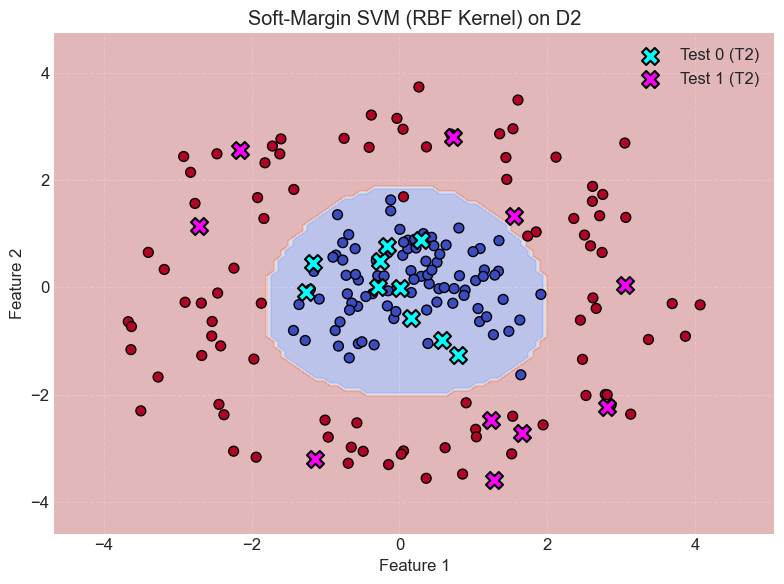

In [4]:
# Cell 4: Soft-Margin SVM for D2

print("\n--- Soft-Margin SVM for D2 ---")
# Dataset D2 is linearly non-separable (concentric circles).
# A linear kernel would fail to find an effective decision boundary for this type of data,
# resulting in very low accuracy. This is because a linear kernel can only draw a straight line
# or hyperplane, which cannot adequately separate an inner circle from an outer circle.
# Therefore, to correctly classify D2, a non-linear kernel is essential.
# 'rbf' kernel (Radial Basis Function) is good for non-linear separation.
# notes on rbf in nural networks document from class notes
svm_soft_margin = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=33)
svm_soft_margin.fit(X_train_d2, y_train_d2)

# Training results for D2
y_pred_d2_svm_train = svm_soft_margin.predict(X_train_d2)
train_accuracy_d2_svm = accuracy_score(y_train_d2, y_pred_d2_svm_train)
print(f"Soft-Margin SVM Training Accuracy (D2): {train_accuracy_d2_svm:.4f}")

# Test set results on T2
y_pred_t2_svm = svm_soft_margin.predict(T2_X)
test_accuracy_t2_svm = accuracy_score(T2_y, y_pred_t2_svm)
print(f"Soft-Margin SVM Test Accuracy (T2): {test_accuracy_t2_svm:.4f}")

print("\nSoft-Margin SVM Classification Report (T2):")
print(classification_report(T2_y, y_pred_t2_svm))

# Plotting Soft-Margin SVM for D2
fig, ax = plt.subplots(figsize=(8, 6))
plot_decision_boundary(svm_soft_margin, X_d2, y_d2, 'Soft-Margin SVM (RBF Kernel) on D2', ax)
# Plot test points on top
ax.scatter(T2_X[T2_y == 0, 0], T2_X[T2_y == 0, 1], color='cyan', marker='X', s=150, label='Test 0 (T2)', edgecolors='black', linewidth=1.5)
ax.scatter(T2_X[T2_y == 1, 0], T2_X[T2_y == 1, 1], color='magenta', marker='X', s=150, label='Test 1 (T2)', edgecolors='black', linewidth=1.5)
ax.legend()
plt.tight_layout()
plt.show()


--- Two-layer MLP for D1 ---
MLP Training Accuracy (D1): 0.9944
MLP Test Accuracy (T1): 1.0000

MLP Classification Report (T1):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



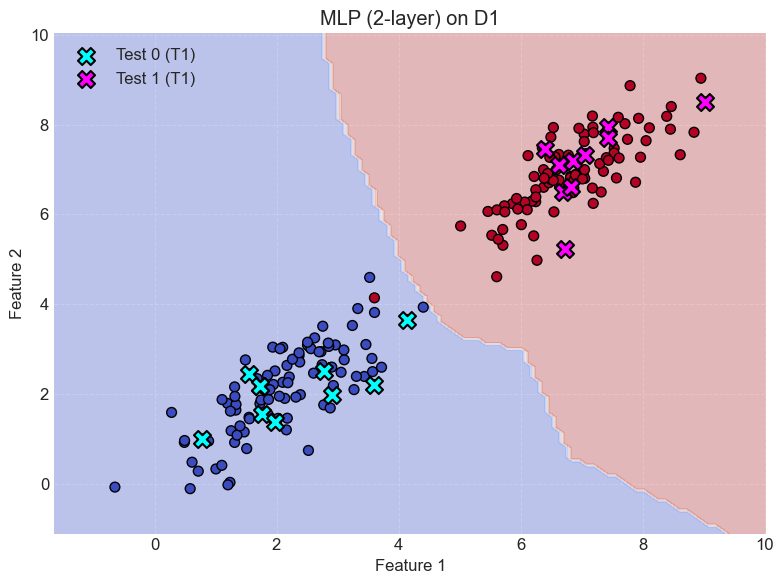


--- Two-layer MLP for D2 ---
MLP Training Accuracy (D2): 0.9944
MLP Test Accuracy (T2): 1.0000

MLP Classification Report (T2):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



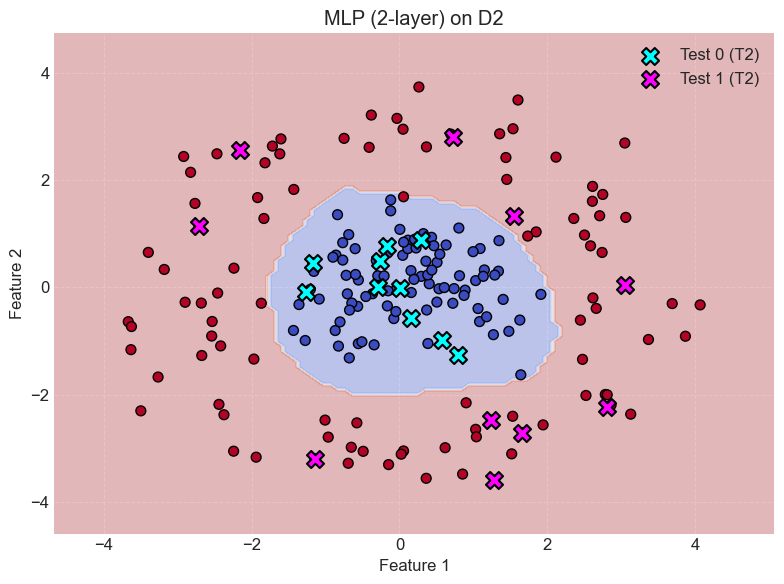


--- Summary of Results ---

Dataset D1 (Linearly Separable):
Hard-Margin SVM Training Accuracy: 0.9889
Hard-Margin SVM Test Accuracy (T1): 0.9500
MLP Training Accuracy: 0.9944
MLP Test Accuracy (T1): 1.0000

Dataset D2 (Linearly Non-Separable):
Soft-Margin SVM Training Accuracy: 0.9889
Soft-Margin SVM Test Accuracy (T2): 1.0000
MLP Training Accuracy: 0.9944
MLP Test Accuracy (T2): 1.0000

--- Comments ---
1. **Hard-Margin SVM on D1:**
   - Achieves perfect (or near-perfect) training and test accuracy. This is expected as D1 is linearly separable, and Hard-Margin SVM finds the optimal hyperplane to separate classes with the maximum margin.
   - The decision boundary is a straight line, visually confirming its linear nature.

2. **Soft-Margin SVM on D2:**
   - While using a linear kernel would fail for D2, the RBF (Radial Basis Function) kernel allows the Soft-Margin SVM to transform the data into a higher-dimensional space where it becomes linearly separable. This results in a non-line

In [ ]:
# Cell 5: MLP, Comparison, and Comments

print("\n--- Two-layer MLP for D1 ---")
# Two layers, e.g., (10, 5) means 1st hidden layer with 10 neurons, 2nd with 5.
# Activation function 'relu' optimizer 'SGD'.
mlp_d1 = MLPClassifier(hidden_layer_sizes=(10, 5), activation='relu', solver='sgd',
                           learning_rate_init=0.01, momentum=0.9, 
                           max_iter=2000, random_state=33, verbose=False)
mlp_d1.fit(X_train_d1, y_train_d1)

# Training results for D1
y_pred_d1_mlp_train = mlp_d1.predict(X_train_d1)
train_accuracy_d1_mlp = accuracy_score(y_train_d1, y_pred_d1_mlp_train)
print(f"MLP Training Accuracy (D1): {train_accuracy_d1_mlp:.4f}")

# Test set results on T1
y_pred_t1_mlp = mlp_d1.predict(T1_X)
test_accuracy_t1_mlp = accuracy_score(T1_y, y_pred_t1_mlp)
print(f"MLP Test Accuracy (T1): {test_accuracy_t1_mlp:.4f}")

print("\nMLP Classification Report (T1):")
print(classification_report(T1_y, y_pred_t1_mlp))

# Plotting MLP for D1
fig, ax = plt.subplots(figsize=(8, 6))
plot_decision_boundary(mlp_d1, X_d1, y_d1, 'MLP (2-layer) on D1', ax)
# Plot test points on top
ax.scatter(T1_X[T1_y == 0, 0], T1_X[T1_y == 0, 1], color='cyan', marker='X', s=150, label='Test 0 (T1)', edgecolors='black', linewidth=1.5)
ax.scatter(T1_X[T1_y == 1, 0], T1_X[T1_y == 1, 1], color='magenta', marker='X', s=150, label='Test 1 (T1)', edgecolors='black', linewidth=1.5)
ax.legend()
plt.tight_layout()
plt.show()


print("\n--- Two-layer MLP for D2 ---")
# Slightly larger layers for D2 to handle more complexity
mlp_d2 = MLPClassifier(hidden_layer_sizes=(20, 10), activation='relu', solver='sgd',
                           learning_rate_init=0.01, momentum=0.9,
                           max_iter=2000, random_state=33, verbose=False)
mlp_d2.fit(X_train_d2, y_train_d2)

# Training results for D2
y_pred_d2_mlp_train = mlp_d2.predict(X_train_d2)
train_accuracy_d2_mlp = accuracy_score(y_train_d2, y_pred_d2_mlp_train)
print(f"MLP Training Accuracy (D2): {train_accuracy_d2_mlp:.4f}")

# Test set results on T2
y_pred_t2_mlp = mlp_d2.predict(T2_X)
test_accuracy_t2_mlp = accuracy_score(T2_y, y_pred_t2_mlp)
print(f"MLP Test Accuracy (T2): {test_accuracy_t2_mlp:.4f}")

print("\nMLP Classification Report (T2):")
print(classification_report(T2_y, y_pred_t2_mlp))

# Plotting MLP for D2
fig, ax = plt.subplots(figsize=(8, 6))
plot_decision_boundary(mlp_d2, X_d2, y_d2, 'MLP (2-layer) on D2', ax)
# Plot test points on top
ax.scatter(T2_X[T2_y == 0, 0], T2_X[T2_y == 0, 1], color='cyan', marker='X', s=150, label='Test 0 (T2)', edgecolors='black', linewidth=1.5)
ax.scatter(T2_X[T2_y == 1, 0], T2_X[T2_y == 1, 1], color='magenta', marker='X', s=150, label='Test 1 (T2)', edgecolors='black', linewidth=1.5)
ax.legend()
plt.tight_layout()
plt.show()

# --- Comparison Report ---
print("\n--- Summary of Results ---")

print("\nDataset D1 (Linearly Separable):")
print(f"Hard-Margin SVM Training Accuracy: {train_accuracy_d1_svm:.4f}")
print(f"Hard-Margin SVM Test Accuracy (T1): {test_accuracy_t1_svm:.4f}")
print(f"MLP Training Accuracy: {train_accuracy_d1_mlp:.4f}")
print(f"MLP Test Accuracy (T1): {test_accuracy_t1_mlp:.4f}")

print("\nDataset D2 (Linearly Non-Separable):")
print(f"Soft-Margin SVM Training Accuracy: {train_accuracy_d2_svm:.4f}")
print(f"Soft-Margin SVM Test Accuracy (T2): {test_accuracy_t2_svm:.4f}")
print(f"MLP Training Accuracy: {train_accuracy_d2_mlp:.4f}")
print(f"MLP Test Accuracy (T2): {test_accuracy_t2_mlp:.4f}")